In [25]:
import pandas as pd
import xarray as xr
import geopandas as gp
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read ERA

The [ERA5-Land monthly averaged Reanalysis-data](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview) has been manually downloaded from the copernicus climate change service.

In [2]:
# tmean and LAI 1968-2023
df1 = xr.open_dataset("data/ERA5/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib", filter_by_keys={'stepType': 'avgid'}).to_dataframe().reset_index().dropna().reset_index(drop=True)
# rain 1968 - 2001
df2 = xr.open_dataset("data/ERA5/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib", filter_by_keys={'stepType': 'avgas'}).to_dataframe().reset_index().dropna().reset_index(drop=True)
# rain 2002-2023
df3 = xr.open_dataset("data/ERA5/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib", filter_by_keys={'stepType': 'avgad'}).to_dataframe().reset_index().dropna().reset_index(drop=True)

rain = pd.concat([df2, df3], ignore_index=True).dropna().reset_index(drop=True)
era = df1.merge(rain, on=["time", "latitude", "longitude", "number", "step", "surface", "valid_time"])

### 2. Preprocess ERA

In [3]:
# Kelvin to Celsius
era["t2m"] = era["t2m"].apply(lambda x: x - 273.15)
# time to datetime
era["time"] = pd.to_datetime(era["time"])
era["valid_time"] = pd.to_datetime(era["valid_time"])

era = (era
       .sort_values(by=["time", "latitude", "longitude"])
       .loc[:, ["time", "latitude", "longitude", "t2m", "tp"]]
       .rename(columns={"latitude":"lat", "longitude":"lon", "t2m":"tmean", "tp":"rain"})
       .reset_index(drop=True))

era["month"] = era["time"].dt.month
era["year"] = era["time"].dt.year
era = era.loc[era["month"].between(9,11) & (era["year"].between(1993,2016))].reset_index(drop=True)
era = era[["time", "lat", "lon", "rain", "tmean", "month", "year"]]
era = gp.GeoDataFrame(era, geometry=gp.points_from_xy(era["lon"], era["lat"], crs="EPSG:4326"))

era.head(2)

,time,lat,lon,rain,tmean,month,year,geometry
0,1993-09-01,-42.0,-69.0,0.000550,3.03335,9,1993,POINT (-69.00000 -42.00000)
1,1993-09-01,-42.0,-68.9,0.000521,2.65835,9,1993,POINT (-68.90000 -42.00000)


### 3. Read Shapefiles and filter relevant wheat cultivating areas

In [4]:
# read subnational wheat series and store unique region names
relevant_areas = pd.read_csv("data/crop/subnational_yield_with_trend.csv")["name"].unique()

# Read ADM2 shapefiles (municipality level) and filter by relevant states
gdf_adm2 = gp.read_file("data/shapefile/arg_admbnda_adm2_unhcr2017.shp")
gdf_adm2["ADM2_ES"] = gdf_adm2["ADM2_ES"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["ADM1_ES"] = gdf_adm2["ADM1_ES"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["name"] = gdf_adm2["ADM1_ES"] + " " + gdf_adm2["ADM2_ES"]

# filter areas 
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(relevant_areas), ["name", "geometry"]].reset_index(drop=True)
gdf_adm2.head()

,name,geometry
0,buenos aires tres arroyos,"POLYGON Z ((-60.16947 -38.17843 0.00000, -60.0..."
1,buenos aires general pinto,"POLYGON Z ((-61.98441 -34.51765 0.00000, -61.8..."
2,buenos aires general juan madariaga,"POLYGON Z ((-57.10996 -36.83308 0.00000, -57.1..."
3,buenos aires necochea,"POLYGON Z ((-59.17038 -37.70095 0.00000, -59.1..."
4,buenos aires pergamino,"POLYGON Z ((-60.81730 -33.54358 0.00000, -60.8..."


#### Plot map of study region

<Axes: >

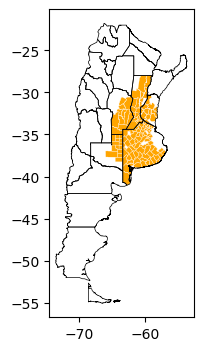

In [5]:
gdf_adm1 = gp.read_file("data/shapefile/arg_admbnda_adm1_unhcr2017.shp").to_crs("EPSG:4326")
base = gdf_adm2.plot(figsize=(4,4), color="orange", edgecolor="white", linewidth=.2)
gdf_adm1.plot(ax=base, color="#FF000000", edgecolor="black", linewidth=0.5)

### 4. Filter ERA by coordinates

In [6]:
# directly spatial join takes too much time
coordinates = gp.sjoin(era[["geometry", "lat", "lon"]].drop_duplicates(), gdf_adm2).reset_index(drop=True)[["name", "lat", "lon"]]
era = era.merge(coordinates[["lat", "lon", "name"]], on=["lat", "lon"], how="right")

# aggregate era across municipality (=name)
era = era.groupby(["name", "time", "year", "month"]).agg({"rain":"mean", "tmean":"mean"}).reset_index()
era.head()

,name,time,year,month,rain,tmean
0,buenos aires 25 de mayo,1993-09-01,1993,9,0.003672,11.504344
1,buenos aires 25 de mayo,1993-10-01,1993,10,0.004624,15.942628
2,buenos aires 25 de mayo,1993-11-01,1993,11,0.005893,18.167580
3,buenos aires 25 de mayo,1994-09-01,1994,9,0.004834,13.180592
4,buenos aires 25 de mayo,1994-10-01,1994,10,0.002982,14.954954


Check if all went well

<Axes: >

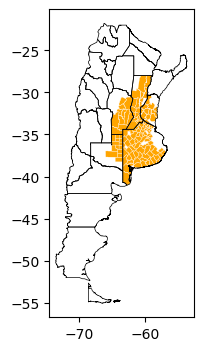

In [7]:
base = gdf_adm2.loc[gdf_adm2["name"].isin(era["name"].unique())].plot(figsize=(4,4), color="orange", edgecolor="white", linewidth=.2)
gdf_adm1.plot(ax=base, color="#FF000000", edgecolor="black", linewidth=0.5)

### 5. Export preprocessed and filtered ERA

In [9]:
era.to_csv("data/ERA5/era_basic_preprocessed_filtered_1993_2016.csv", index=False)

### 6. Restructure dataset

In [18]:
era_features = era.pivot(index="year", columns=["name", "month"], values=["rain", "tmean"])
era_features.columns = ["{}_{}_{}".format(s[0],s[1],s[2]) for s in era_features.columns]
era_features = era_features.reset_index()
era_features.head()

,year,rain_buenos aires 25 de mayo_9,rain_buenos aires 25 de mayo_10,rain_buenos aires 25 de mayo_11,rain_buenos aires 9 de julio_9,rain_buenos aires 9 de julio_10,rain_buenos aires 9 de julio_11,rain_buenos aires adolfo alsina_9,rain_buenos aires adolfo alsina_10,rain_buenos aires adolfo alsina_11,...,tmean_santa fe san justo_11,tmean_santa fe san lorenzo_9,tmean_santa fe san lorenzo_10,tmean_santa fe san lorenzo_11,tmean_santa fe san martin_9,tmean_santa fe san martin_10,tmean_santa fe san martin_11,tmean_santa fe vera_9,tmean_santa fe vera_10,tmean_santa fe vera_11
0,1993,0.003672,0.004624,0.005893,0.003883,0.004158,0.006154,0.001277,0.002418,0.005371,...,20.987172,13.181299,17.686621,19.747070,13.869561,18.270352,20.244004,16.723047,20.544873,21.863350
1,1994,0.004834,0.002982,0.001956,0.002992,0.002993,0.001888,0.000614,0.002181,0.001818,...,21.844978,15.849854,17.330029,21.368066,16.644229,18.007529,21.269316,19.528076,20.530674,22.216523
2,1995,0.000535,0.002790,0.001777,0.000537,0.002799,0.002493,0.000382,0.001937,0.003436,...,23.485742,16.013330,17.024316,21.444287,16.618955,17.346777,22.001201,18.648125,19.918408,25.476445
3,1996,0.001618,0.003890,0.004558,0.001404,0.003781,0.003973,0.000740,0.002251,0.004578,...,22.955329,14.559570,18.583643,21.834033,14.714336,18.796045,22.390439,17.608613,20.811484,23.387070
4,1997,0.001301,0.005324,0.005031,0.001263,0.005907,0.004336,0.001579,0.003742,0.002059,...,22.493659,15.282617,17.721826,20.458887,16.177031,18.135732,20.880957,19.520986,20.985488,23.198037


In [19]:
era_features.to_csv("data/ERA5/era_basic_preprocessed_filtered_feature_structure_1993_2016.csv", index=False)

### 7. Basis Expansion

In [10]:
def standardize_loyo(data):
    data = data.copy()
    standardized_data = []
    for year in list(range(1993, 2017)):
        # split
        features_used_for_standardization = data.loc[data["year"] != year, [c for c in data.columns if c != "year"]].reset_index(drop=True).copy()
        features_to_standardize = data.loc[(data["year"] == year), [c for c in data.columns if c != "year"]].reset_index(drop=True).copy()
        # standardize
        features_standardized = (features_to_standardize - features_used_for_standardization.mean()) / features_used_for_standardization.std()
        # bring it together
        year = data.loc[(data["year"] == year), ["year"]].reset_index(drop=True)
        standardized_df = pd.concat([year, features_standardized], axis=1)
        standardized_data.append(standardized_df)
    df_standardized = pd.concat(standardized_data, ignore_index=True)
    return df_standardized

def apply_basis_expansion(data):
    """
    apply basis expansion to feature-dataframe and return as new dataframe, where original features are replaced with new ones.
    params:
        data: dataframe, with the original features; monthly tmean and monthly rainfall
    returns:
        data_expanded: dataframe, with original features and tmean_squared, rain_squared, and tmean_times_rain features
    """
    df_standardized = standardize_loyo(data)
    
    # store features and target in variables for better readability
    X_temp = df_standardized.loc[:, [c for c in df_standardized.columns if ("tmean" in c)]]
    X_rain = df_standardized.loc[:, [c for c in df_standardized.columns if ("rain" in c)]]
    y = df_standardized.loc[:, ["year"]].reset_index(drop=True)
    
    # basis expansion to linear model
    X_tmean_squared = X_temp.mul(X_temp)
    X_rain_squared = X_rain.mul(X_rain)
    X_rain_tmean = X_rain * X_temp.values
    X_tmean_squared.columns = ["tmeansquared_{}".format("_".join(c.split("_")[1:])) for c in X_tmean_squared.columns]
    X_rain_squared.columns = ["rainsquared_{}".format("_".join(c.split("_")[1:])) for c in X_rain_squared.columns]
    X_rain_tmean.columns = ["tmeanrain_{}".format("_".join(c.split("_")[1:])) for c in X_rain_tmean.columns]
    
    # merge to feature dataframe
    X = (X_tmean_squared.merge(X_rain_squared.merge(X_rain_tmean, left_index=True, right_index=True), left_index=True, right_index=True))
    data_expanded = pd.concat([y, X], axis=1)

    # standardize expanded features again
    df_standardized = standardize_loyo(data_expanded)
    
    return df_standardized

In [13]:
era_basis_expansion = apply_basis_expansion(era_features)

In [14]:
era_basis_expansion.head(5)

,year,tmeansquared_buenos aires 25 de mayo_9,tmeansquared_buenos aires 25 de mayo_10,tmeansquared_buenos aires 25 de mayo_11,tmeansquared_buenos aires 9 de julio_9,tmeansquared_buenos aires 9 de julio_10,tmeansquared_buenos aires 9 de julio_11,tmeansquared_buenos aires adolfo alsina_9,tmeansquared_buenos aires adolfo alsina_10,tmeansquared_buenos aires adolfo alsina_11,...,tmeanrain_santa fe san justo_11,tmeanrain_santa fe san lorenzo_9,tmeanrain_santa fe san lorenzo_10,tmeanrain_santa fe san lorenzo_11,tmeanrain_santa fe san martin_9,tmeanrain_santa fe san martin_10,tmeanrain_santa fe san martin_11,tmeanrain_santa fe vera_9,tmeanrain_santa fe vera_10,tmeanrain_santa fe vera_11
0,1993,1.420914,-0.759344,-0.111418,1.650211,-0.681814,0.048171,-0.865437,-0.416741,0.433436,...,-1.042311,1.285535,-2.187527,-0.110478,0.905252,-2.511513,-0.009291,-0.176854,-0.882908,-0.522672
1,1994,-0.745486,0.285874,-0.499296,-0.713366,0.162838,-0.521486,-1.004409,-0.051197,-0.206265,...,0.355199,0.317717,0.347394,0.130898,-0.695378,-0.738003,0.676131,0.631222,-0.332272,-0.112972
2,1995,0.318928,-0.535790,-0.165268,0.266707,-0.547644,-0.199212,1.371210,-0.432583,-0.371917,...,-0.019850,-0.865199,0.260512,0.693938,-0.187505,0.706068,0.760318,0.127005,0.857300,-0.945633
3,1996,-0.724858,-0.471265,-0.491809,-0.738947,-0.477909,-0.508099,-1.075557,-0.033144,-0.348922,...,0.315138,-0.397661,0.173485,0.414783,-2.279832,0.572098,0.279546,-0.103459,-0.115101,-0.068385
4,1997,-0.237318,-0.312693,-0.022394,-0.463733,-0.193820,0.057132,-0.309702,-0.012604,0.139958,...,0.145713,-0.521720,-0.213591,0.019002,-0.195331,-0.585438,0.055980,-0.667665,-0.214382,-0.110377


In [15]:
era_basis_expansion.to_csv("data/features/era_basis_expansion_features_1993_2016.csv", index=False)